<a href="https://colab.research.google.com/github/houpingx/DataManagement/blob/main/Textual_Analysis_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
In this code, we will introduce both topic modeling and sentiment analysis for textual analysis

# Topic Modeling
Gensim is python package used a lot to extract topics from a corpus. Next, we will build a topic model using the Latent Dirichlet Allocation (LDA) algorithm, and more importantly, we will show how to present and visualize the topic model results.


1.   The algorithm in Genism used is call LdaModel https://radimrehurek.com/gensim/models/ldamodel.html
2.   To effectively visualize the results, we will use matplotlib and pyLDAvis https://pyldavis.readthedocs.io/en/latest/modules/API.html



### import packages

In [ ]:
! pip install pyLDAvis

In [ ]:
import sys
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle # Sentence Coloring of N Sentences
from matplotlib.ticker import FuncFormatter

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# NLTK Stop words
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


### import stopwords from NLTK

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

generate the stopword list

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [ ]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Read news data

In [ ]:
data = pd.read_json('https://raw.githubusercontent.com/houpingx/houpingx.github.io/main/DB/newsgroups.json')
# select news from five topics (target_names): 'comp.graphics', 'rec.sport.baseball', 'talk.politics.mideast', 'soc.religion.christian'
data = data.loc[data.target_names.isin(['comp.graphics', 'rec.sport.baseball', 'talk.politics.mideast', 'soc.religion.christian']) , :]
data = data.reset_index(drop=True)
print('Shape of the dataframe :')
print(data.shape)
print('Display the top 5 news :')
data.head(5)

Shape of the dataframe :
(2344, 3)
Display the top 5 news :


,content,target,target_names
0,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
1,From: ab@nova.cc.purdue.edu (Allen B)\nSubject...,1,comp.graphics
2,From: kph2q@onyx.cs.Virginia.EDU (Kenneth Hinc...,1,comp.graphics
3,From: r4938585@joplin.biosci.arizona.edu (Doug...,9,rec.sport.baseball
4,From: jonh@david.wheaton.edu (Jonathan Hayward...,15,soc.religion.christian


In [ ]:
# generate the corpus that contains all news
corpus_raw = data.content.values.tolist()

In [ ]:
corpus_raw[0]

'From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice.  It\'s got this\n> quadrilateral fill command that requires just the four points.\n\nDo you have Weitek\'s address/phone number?  I\'d like to get some information\nabout this chip.\n\n--\nJoe Green\t\t\t\tHarris Corporation\njgreen@csd.harris.com\t\t\tComputer Systems Division\n"The only thing that really scares me is a person with no sense of humor."\n\t\t\t\t\t\t-- Jonathan Winters\n'

### Preprocess and clean the text data


1.   Tokenize each sentences, that is, breaking a sentence into a list of words. For instance, 'Everyone gets good grade in msa8040' --> ['everyone', 'get', 'good', 'grade', 'in', 'msa8040']
2.   Remove some unuseful words, punctuations, markers, numbers (maybe), etc.



Gensim provides a simple solution, simple_preprocess(doc, deacc, min_len, max-len), where deacc=True is to remove punctuations

In [ ]:
def tokenize_sentence(sentences):
    """ this functionn is to preprocess each news and tokenize each news"""
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent) 

In [ ]:
data.content[0]

'From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:\n> > Anyone know about the Weitek P9000 graphics chip?\n> As far as the low-level stuff goes, it looks pretty nice.  It\'s got this\n> quadrilateral fill command that requires just the four points.\n\nDo you have Weitek\'s address/phone number?  I\'d like to get some information\nabout this chip.\n\n--\nJoe Green\t\t\t\tHarris Corporation\njgreen@csd.harris.com\t\t\tComputer Systems Division\n"The only thing that really scares me is a person with no sense of humor."\n\t\t\t\t\t\t-- Jonathan Winters\n'

In [ ]:
# check the example of how the result looks like
print(list(tokenize_sentence([data.content[0]])))

[['from', 'joe', 'green', 'subject', 're', 'weitek', 'organization', 'harris', 'computer', 'systems', 'division', 'lines', 'distribution', 'world', 'nntp', 'posting', 'host', 'amber', 'ssd', 'csd', 'harris', 'com', 'newsreader', 'tin', 'version', 'pl', 'robert', 'kyanko', 'wrote', 'writes', 'in', 'article', 'anyone', 'know', 'about', 'the', 'weitek', 'graphics', 'chip', 'as', 'far', 'as', 'the', 'low', 'level', 'stuff', 'goes', 'it', 'looks', 'pretty', 'nice', 'its', 'got', 'this', 'quadrilateral', 'fill', 'command', 'that', 'requires', 'just', 'the', 'four', 'points', 'do', 'you', 'have', 'weiteks', 'address', 'phone', 'number', 'id', 'like', 'to', 'get', 'some', 'information', 'about', 'this', 'chip', 'joe', 'green', 'harris', 'corporation', 'computer', 'systems', 'division', 'the', 'only', 'thing', 'that', 'really', 'scares', 'me', 'is', 'person', 'with', 'no', 'sense', 'of', 'humor', 'jonathan', 'winters']]


In [ ]:
# Tokenize all documents in the corpus
document_words = list(tokenize_sentence(corpus_raw))

In [ ]:
len(document_words)

2344

### Data transformer
We keep cleaning the data for furture representation. Usually, a good document representation will yield a better performance. To do that, we consider the Lemmatize, phrases, etc

1.   Lemmatize: convert each word into its root form. For instance, working|worked|works --> work
2. Consider only meaningful words, such as nouns, adjectives, verbs and adverbs, by removing the stop words
2.   Phrases: besides single word, we also want to consider phrases. For instance, 'text mining' should be considered as togethor. we use Phrases() in Genism to extract phrases with different number of words
https://radimrehurek.com/gensim/models/phrases.html

*   min_count (float, optional) – Ignore all words and bigrams with total collected count lower than this value.
*   threshold (float, optional) – Represent a score threshold for forming the phrases (higher means fewer phrases). A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. Heavily depends on concrete scoring-function, see the scoring parameter.




##### Build the phrase models
We use the phrase to atuomatically detect common phrases, i.e., multi-word expression, word n-gram words, from the corpus

In [ ]:
bigram = gensim.models.Phrases(document_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[document_words], threshold=100)
#
fourthgram = trigram = gensim.models.Phrases(trigram[document_words], threshold=100)
# you can keep going for 4-gram, 5-gram, etc

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


##### Export the trained phrase model
We can use phraser to export the trained phrase model. In this way, it will use less RAM and will be faster processing

In [ ]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
print(bigram_mod[document_words[0]])

['from', 'joe', 'green', 'subject_re', 'weitek', 'organization', 'harris', 'computer', 'systems', 'division', 'lines', 'distribution_world', 'nntp_posting', 'host', 'amber', 'ssd', 'csd', 'harris', 'com', 'newsreader_tin', 'version_pl', 'robert_kyanko', 'wrote', 'writes', 'in', 'article', 'anyone', 'know', 'about', 'the', 'weitek', 'graphics', 'chip', 'as', 'far', 'as', 'the', 'low_level', 'stuff', 'goes', 'it', 'looks', 'pretty', 'nice', 'its', 'got', 'this', 'quadrilateral', 'fill', 'command', 'that', 'requires', 'just', 'the', 'four', 'points', 'do', 'you', 'have', 'weiteks', 'address', 'phone', 'number', 'id', 'like', 'to', 'get', 'some', 'information', 'about', 'this', 'chip', 'joe', 'green', 'harris', 'corporation', 'computer', 'systems', 'division', 'the', 'only', 'thing', 'that', 'really', 'scares', 'me', 'is', 'person', 'with', 'no', 'sense', 'of', 'humor', 'jonathan', 'winters']


In [ ]:
# apply the trained phrases model to a new, unseen sentence
print(bigram[['low','level','distribution','world','hello']]);

['low_level', 'distribution_world', 'hello']


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
print(trigram[document_words[10]])

['from', 'serdar_argic', 'subject', 'day', 'and', 'night', 'armenians', 'were', 'rounding', 'up', 'male', 'inhabitants', 'article', 'zuma', 'reply', 'to', 'serdar_argic', 'distribution_world', 'lines', 'in', 'article', 'eduard', 'wiener', 'writes', 'sure', 'it', 'joined', 'you', 'by', 'ballot', 'in', 'and', 'suppose', 'that', 'northern', 'bukovina', 'where', 'was', 'born', 'which', 'has', 'always', 'had', 'thats', 'why', 'zoologists', 'refer', 'to', 'you', 'as', 'fecal', 'shield', 'colonel', 'semen', 'budienny', 'subsequent', 'soviet', 'military', 'fame', 'said', 'about', 'the', 'armenian', 'genocide', 'of', 'million', 'defenseless', 'turkish', 'and', 'kurdish', 'women', 'children', 'and', 'elderly', 'people', 'during', 'his', 'visit', 'to', 'anatolia', 'in', 'june', 'that', 'the', 'armenians', 'had', 'become', 'troublemakers', 'their', 'hinchakist', 'and', 'dashnakist', 'parties', 'were', 'opportunist', 'serving', 'as', 'lackeys', 'of', 'whatever', 'power', 'happened', 'to', 'be', 'as

In [ ]:
def preprocess_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove stopwords, bigrams phrases, trigrams and lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts] # remove stopwords
    texts = [bigram_mod[doc] for doc in texts] # find bigram phrases
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts] # find trigram phrases
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags]) # lemmatization
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [ ]:
data_clean = preprocess_words(document_words);  # apply to the corpus that you would like to implement topic modeling

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


In [ ]:
print(data_clean[0])

['system', 'division', 'host', 'write', 'write', 'article', 'chip', 'far', 'low_level', 'stuff', 'look', 'pretty', 'quadrilateral', 'fill', 'command', 'require', 'point', 'weitek', 'address', 'information', 'chip', 'system', 'division', 'thing', 'really', 'scare', 'person', 'sense']


### Build a Topic Model
We use LdaModel() to train a topic model. To successful train a topic model, we need provide both the corpus and the dictionary from the corpus. 
A dictionary is the list of unique words in that corpus, based on the threshold we provide, regarding the word frequency

#### generate the dictionary

In [ ]:
id2word = corpora.Dictionary(data_clean);

In [ ]:
len(id2word)

18153

In [ ]:
id2word.get(1)

'article'

In [ ]:
id2word.get(2)

'chip'

#### Document/corpus representation
We use the word frequency to represent each document, that is, term-document frequency

In [ ]:
corpus = [id2word.doc2bow(text) for text in data_clean]

In [ ]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 2),
 (3, 1),
 (4, 2),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 2),
 (21, 1),
 (22, 1),
 (23, 2)]

#### LDA model

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # the corpus representation
                                           id2word=id2word, # the dictionary extracted from the corpus
                                           num_topics=4, # hyper parameter: how many topics do we want
                                           random_state=100, # this serves as a seed (in case you wanted to repeat exactly the training process)
                                           update_every=1, # update the model every update_every chunksize chunks (essentially, this is for memory consumption optimization)
                                           chunksize=10, # number of documents to consider at once (affects the memory consumption)
                                           passes=10, # how many times the algorithm is supposed to pass over the whole corpus
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True) #setting this to True allows for extraction of the most likely topics given a word. The training process is set in such a way that every word will be assigned to a topic. Otherwise, words that are not indicative are going to be omitted.


In [ ]:
# print topics
pprint(lda_model.print_topics())

[(0,
  '0.014*"system" + 0.012*"point" + 0.010*"write" + 0.010*"organization" + '
  '0.009*"program" + 0.008*"look" + 0.008*"work" + 0.008*"source" + '
  '0.007*"help" + 0.007*"sphere"'),
 (1,
  '0.011*"people" + 0.010*"greek" + 0.009*"israeli" + 0.008*"turk" + '
  '0.008*"state" + 0.007*"kill" + 0.006*"turkish" + 0.006*"article" + '
  '0.006*"government" + 0.006*"armenian"'),
 (2,
  '0.018*"game" + 0.014*"team" + 0.013*"year" + 0.012*"write" + 0.012*"win" + '
  '0.011*"article" + 0.010*"play" + 0.010*"player" + 0.009*"lose" + '
  '0.009*"hit"'),
 (3,
  '0.011*"people" + 0.011*"reason" + 0.010*"evidence" + 0.010*"write" + '
  '0.010*"believe" + 0.008*"thing" + 0.007*"question" + 0.006*"faith" + '
  '0.006*"way" + 0.006*"sense"')]


##### Find Main topics
Extract the distribution of topics per document

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the dominant topic, distribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Main Topic', 'Topic Percentage', 'Topic Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = sent_topics_df.rename(columns={0:'Text'})
    return(sent_topics_df)

In [ ]:
topics_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_clean)

# Format
dominant_topic = topics_keywords.reset_index()
dominant_topic.columns = ['Document Id', 'Main Topic Id', 'Main Topic Percentage', 'Keywords', 'Text']
dominant_topic.head(5)

,Document Id,Main Topic Id,Main Topic Percentage,Keywords,Text
0,0,0.0,0.5187,"system, point, write, organization, program, l...","[system, division, host, write, write, article..."
1,1,0.0,0.5633,"system, point, write, organization, program, l...","[organization, article, write, reading, write,..."
2,2,0.0,0.7163,"system, point, write, organization, program, l...","[input, vendor, information, look, add, voice,..."
3,3,2.0,0.5321,"game, team, year, write, win, article, play, p...","[tucson, keyword, game, length, let, spos]"
4,4,3.0,0.7230,"people, reason, evidence, write, believe, thin...","[article, write, new, group, maybe, cover, alr..."


In [ ]:
topics_keywords

,Main Topic,Topic Percentage,Topic Keywords,Text
0,0.0,0.5187,"system, point, write, organization, program, l...","[system, division, host, write, write, article..."
1,0.0,0.5633,"system, point, write, organization, program, l...","[organization, article, write, reading, write,..."
2,0.0,0.7163,"system, point, write, organization, program, l...","[input, vendor, information, look, add, voice,..."
3,2.0,0.5321,"game, team, year, write, win, article, play, p...","[tucson, keyword, game, length, let, spos]"
4,3.0,0.7230,"people, reason, evidence, write, believe, thin...","[article, write, new, group, maybe, cover, alr..."
...,...,...,...,...
2339,3.0,0.4406,"people, reason, evidence, write, believe, thin...","[quick, question, organization, psychology, wr..."
2340,1.0,0.6875,"people, greek, israeli, turk, state, kill, tur...","[math, unsw, organization, school, mathematic,..."
2341,3.0,0.9319,"people, reason, evidence, write, believe, thin...","[mark_baker, arrogance, christian, reply, mark..."
2342,1.0,0.7899,"people, greek, israeli, turk, state, kill, tur...","[com, reply, message, article, write, first, p..."


##### Representative words in each topic
How to extract the most representative words in each topic, which may be useful?

In [ ]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = topics_keywords.groupby('Main Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic Percentage'], ascending=False).head(1)], 
                                            axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic Id', "Topic Percentage", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic Id,Topic Percentage,Keywords,Representative Text
0,0.0,0.9824,"system, point, write, organization, program, l...","[comp_graphic, cad, rtrace, keyword, ray_trace..."
1,1.0,0.9891,"people, greek, israeli, turk, state, kill, tur...","[armenian, genocide, muslim, people, article, ..."
2,2.0,0.9724,"game, team, year, write, win, article, play, p...","[shortstop, organization, article, brett_roger..."
3,3.0,0.9934,"people, reason, evidence, write, believe, thin...","[cause, write, write, stuff_delete, fortunatel..."


##### Words frequency in corpus

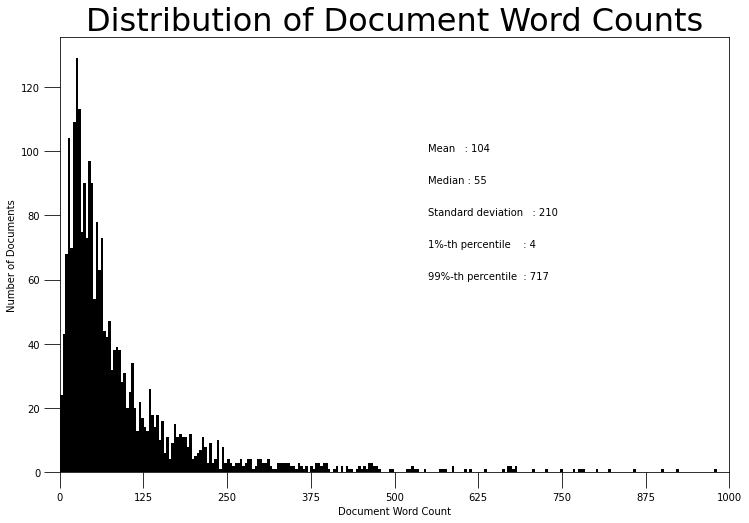

In [ ]:
doc_lens = [len(d) for d in dominant_topic.Text]

# Plot
plt.figure(figsize=(12,8))
plt.hist(doc_lens, bins = 1000, color='k')
plt.text(550, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(550,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(550,  80, "Standard deviation   : " + str(round(np.std(doc_lens))))
plt.text(550,  70, "1%-th percentile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(550,  60, "99%-th percentile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=32))
plt.show()

##### Words frequency per topics

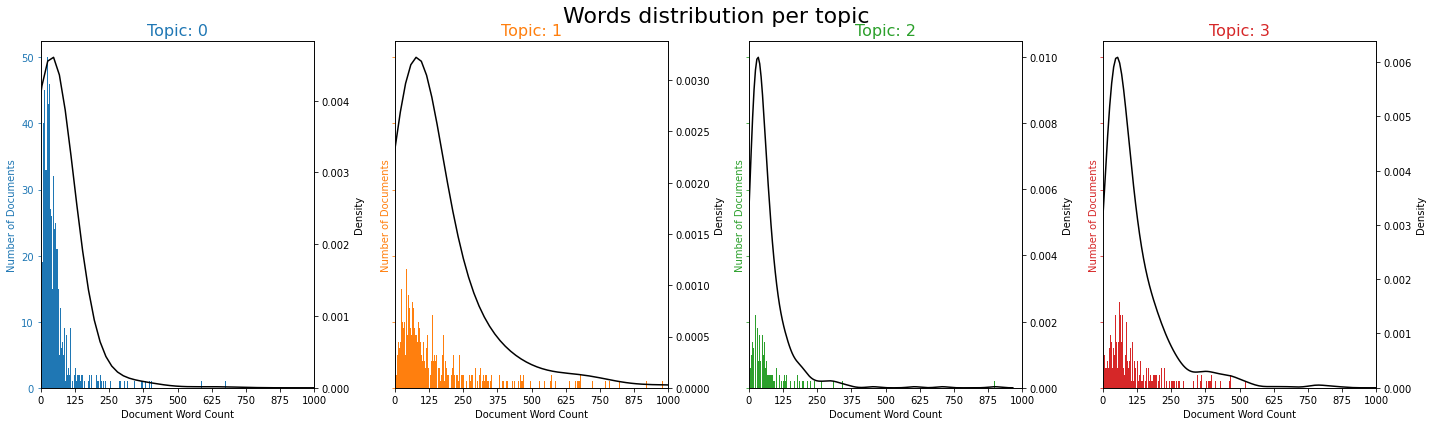

In [ ]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
fig, axes = plt.subplots(1,4,figsize=(20,6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = dominant_topic.loc[dominant_topic['Main Topic Id'] == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Words distribution per topic', fontsize=22)
plt.show()

##### Word clouds
Word clouds is another tool to visulize the words in each topic.

In [ ]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

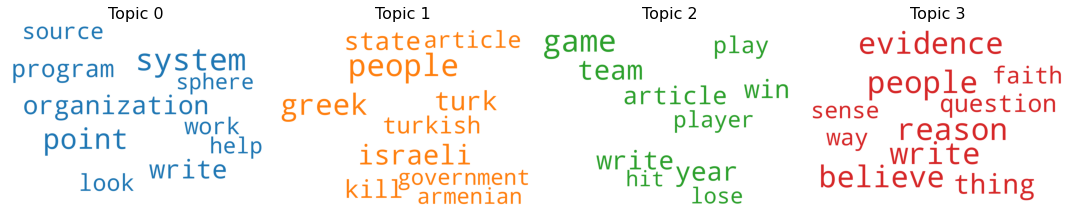

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

##### Important words in each topic
We identify keywords from each topic based on their importance

In [ ]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_clean for w in w_list]
counter = Counter(data_flat)

In [ ]:
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic id', 'importance', 'word count'])        


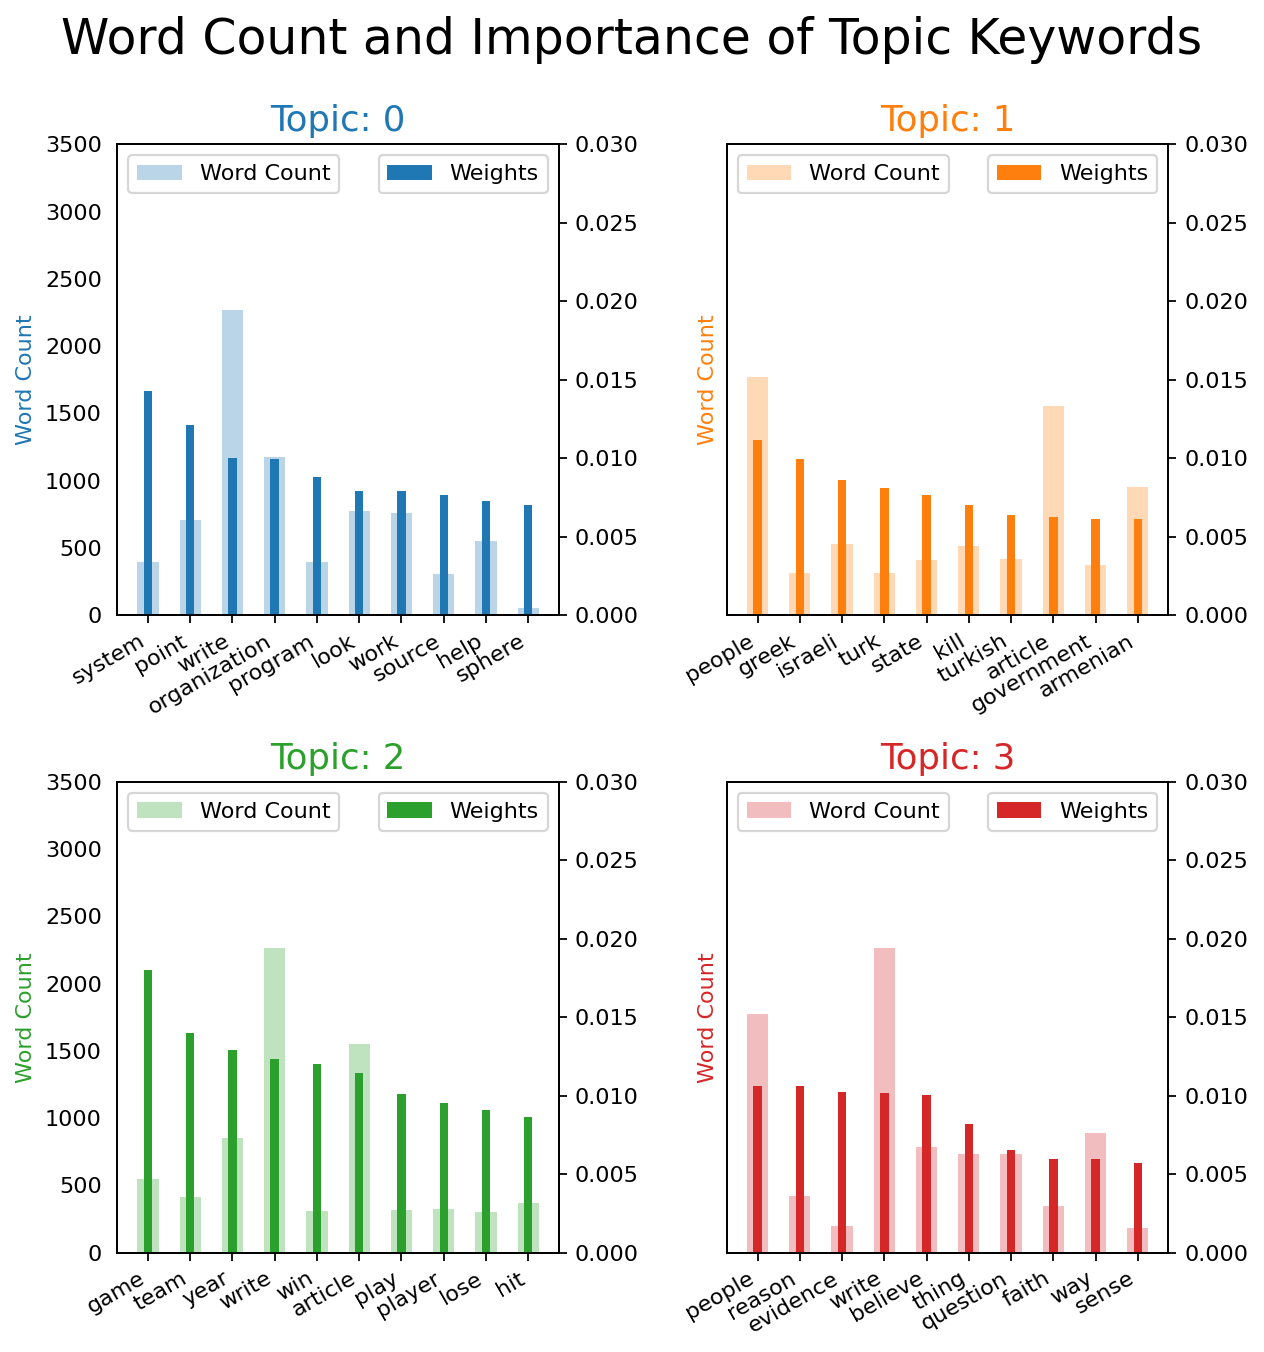

In [ ]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(8,8), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word count", data=df.loc[df['topic id']==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df['topic id']==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df['topic id']==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()


##### Visulize topic in each sentence
each word in the document is representative of one topic. Therefore, based on their probabbility, we can plot which topic each word belongs to in each sentence.

In [ ]:
from matplotlib.patches import Rectangle
def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 20:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()   

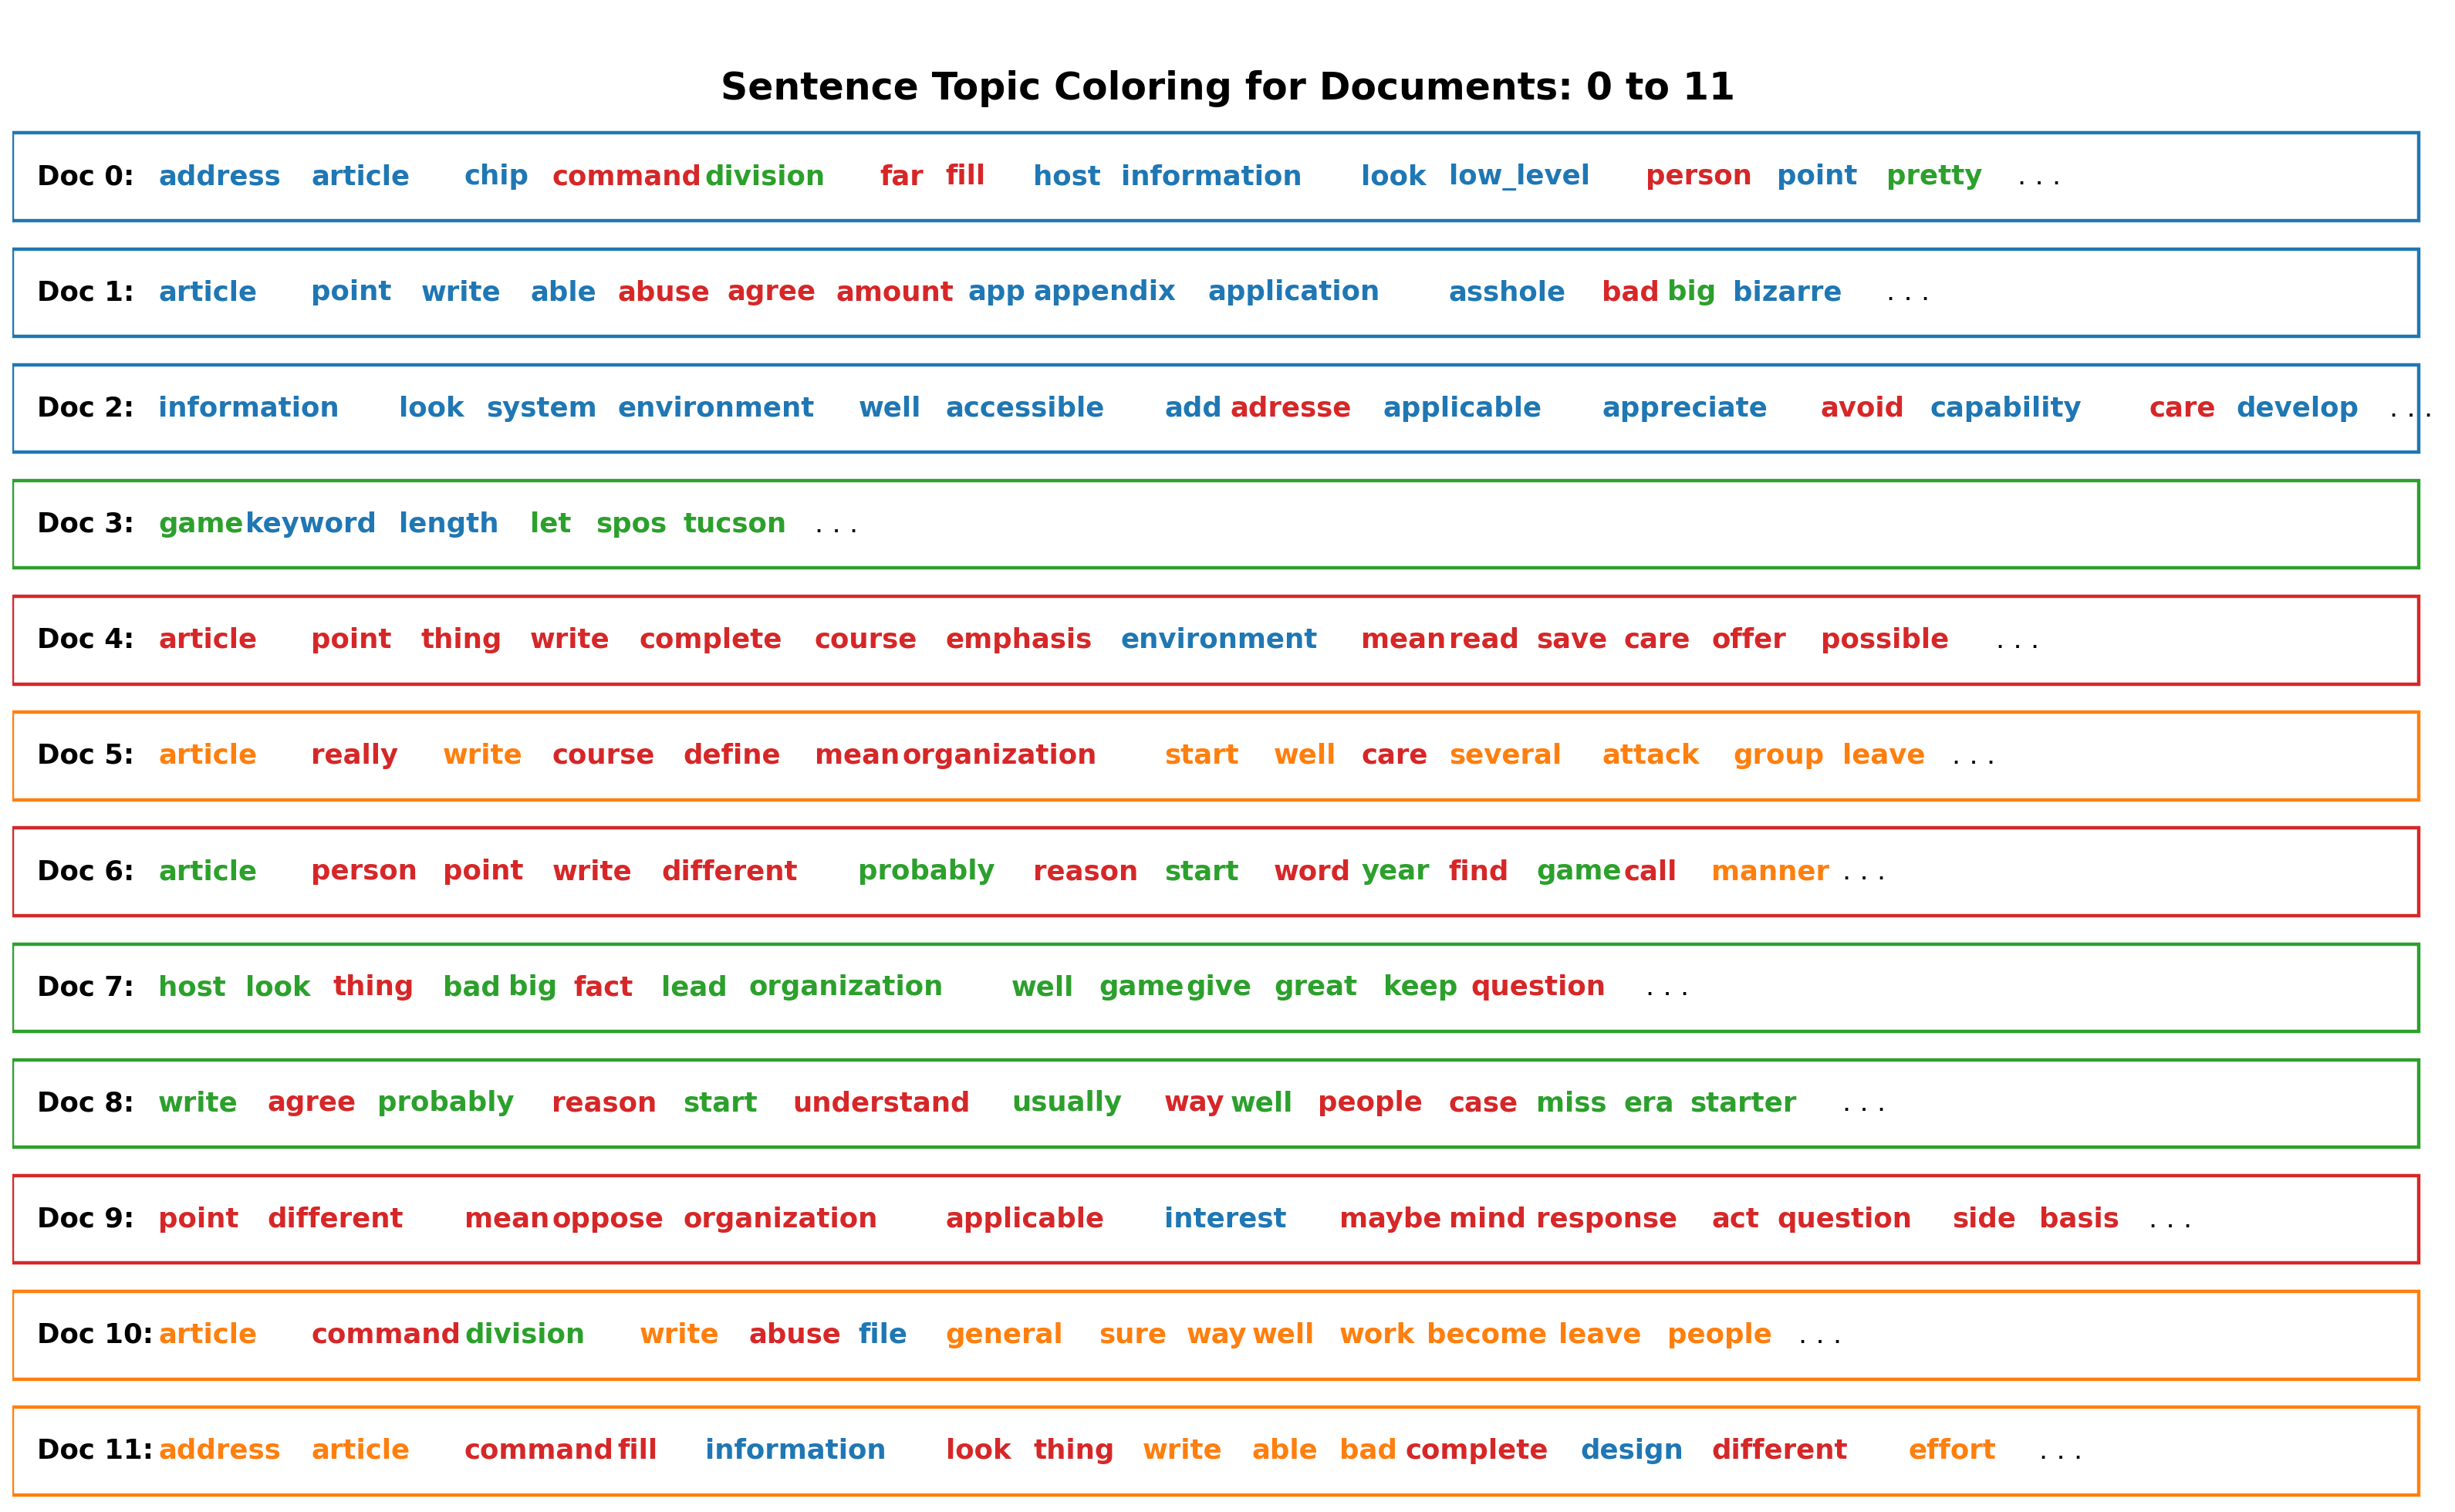

In [ ]:
sentences_chart() 

##### Most important topic
Which topic is most discussed in the corpus?

In [ ]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

In [ ]:
dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 5 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 5]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

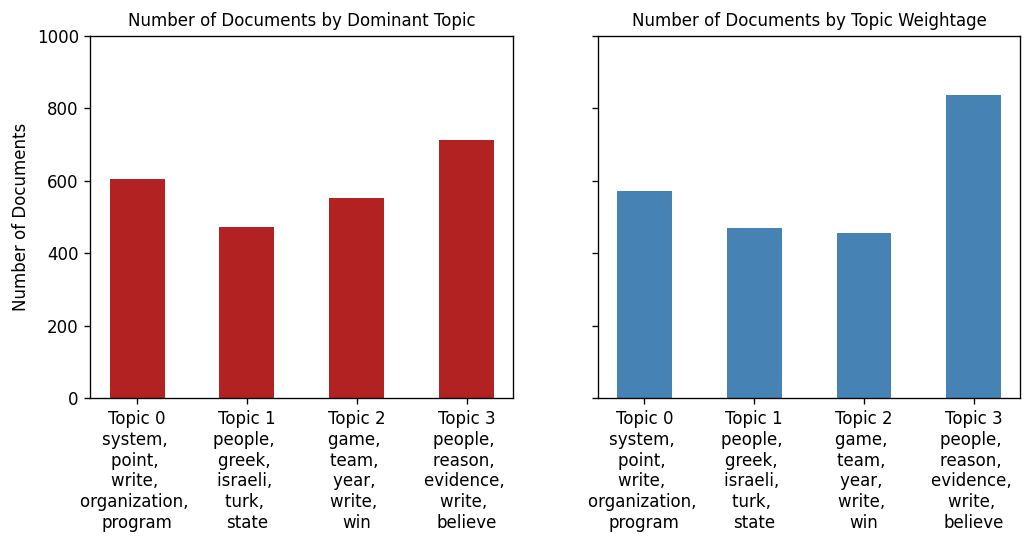

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

##### clustering
Visualize the clusters of documents in the corpus using t-SNE algorithm

In [ ]:
vector = lda_model[corpus[0]]

In [ ]:
vector

([(0, 0.5186598), (2, 0.16396946), (3, 0.30861685)],
 [(0, [0]),
  (1, [0, 2, 3]),
  (2, [0]),
  (3, [3, 0]),
  (4, [2]),
  (5, [3, 2]),
  (6, [3, 0]),
  (7, [0, 2]),
  (8, [0]),
  (9, [0, 2, 3]),
  (10, [0, 2, 3]),
  (11, [3]),
  (12, [0, 3, 2]),
  (13, [2, 3, 0]),
  (14, [0, 2, 3]),
  (15, [3, 2]),
  (16, [0, 3]),
  (17, [3]),
  (18, [3]),
  (19, [0]),
  (20, [0]),
  (21, [3, 0]),
  (22, [0, 2, 3]),
  (23, [0, 3, 2])],
 [(0, [(0, 0.9993969)]),
  (1, [(0, 0.49287754), (2, 0.2581455), (3, 0.24846189)]),
  (2, [(0, 1.9986731)]),
  (3, [(0, 0.06064347), (3, 0.9382909)]),
  (4, [(2, 1.9982655)]),
  (5, [(2, 0.23402426), (3, 0.75570905)]),
  (6, [(0, 0.21946208), (3, 0.7801754)]),
  (7, [(0, 0.9567421), (2, 0.04319566)]),
  (8, [(0, 0.9999474)]),
  (9, [(0, 0.7062646), (2, 0.17328252), (3, 0.120452814)]),
  (10, [(0, 0.9437816), (2, 0.036340673), (3, 0.019821046)]),
  (11, [(3, 0.99849385)]),
  (12, [(0, 0.79868865), (2, 0.02317409), (3, 0.17810984)]),
  (13, [(0, 0.16123867), (2, 0.654166

In [ ]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Main topic number in each document
topic_num = np.argmax(arr, axis=1)

# tSNE dimension reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2327 samples in 0.002s...
[t-SNE] Computed neighbors for 2327 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2327
[t-SNE] Computed conditional probabilities for sample 2000 / 2327
[t-SNE] Computed conditional probabilities for sample 2327 / 2327
[t-SNE] Mean sigma: 0.036817
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.158371
[t-SNE] KL divergence after 1000 iterations: 0.518294


##### pyLDAVis
pyLDAVis is the most commonly used approach to visulaize the informative words in each topic, generated by the topic model

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.141355 -0.042932       1        1  39.148200
1      0.191353  0.000907       2        1  28.755772
0     -0.195653 -0.198897       3        1  18.786727
2     -0.137055  0.240922       4        1  13.309301, topic_info=             Term         Freq        Total Category  logprob  loglift
140          game   588.000000   588.000000  Default  30.0000  30.0000
20         system   658.000000   658.000000  Default  29.0000  29.0000
82         reason  1019.000000  1019.000000  Default  28.0000  28.0000
433          team   456.000000   456.000000  Default  27.0000  27.0000
103          year   726.000000   726.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
9            look   216.382373   804.485326   Topic4  -5.0144   0.7036
72   organization   248.348181  1239.652898   Topic4  -4.8766   0.4090
226          time   229.567706  1118.141240   Topic4  -4.9552   0.4335
176          give   166.594178   940.424974   Topic4  -5.2759   0.2859
32            bad   130.187018   529.687865   Topic4  -5.5224   0.6134

[222 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4839      4  0.990586      aaa
146       1  0.994962   accept
5174      2  0.093475  advance
5174      3  0.903592  advance
26        1  0.970318    agree
...     ...       ...      ...
23        3  0.204707    write
23        4  0.178952    write
1583      1  0.995590    wrong
103       2  0.420033     year
103       4  0.578406     year

[245 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [ ]:
ddd = pd.DataFrame(topic_weights).fillna(0)
arr = pd.DataFrame(topic_weights).fillna(0).values
ddd['topic']= np.argmax(arr, axis=1)
ddd['real topic'] = data['target_names']

In [ ]:
ddd[ddd['topic']==0]['real topic'].value_counts()

comp.graphics             554
talk.politics.mideast     116
rec.sport.baseball         77
soc.religion.christian     24
Name: real topic, dtype: int64

In [ ]:
ddd[ddd['topic']==1]['real topic'].value_counts()

talk.politics.mideast     359
rec.sport.baseball        186
soc.religion.christian    124
comp.graphics               5
Name: real topic, dtype: int64

In [ ]:
ddd[ddd['topic']==2]['real topic'].value_counts()

rec.sport.baseball        312
soc.religion.christian    232
talk.politics.mideast      48
comp.graphics               9
Name: real topic, dtype: int64

In [ ]:
ddd[ddd['topic']==3]['real topic'].value_counts()

soc.religion.christian    219
talk.politics.mideast      41
rec.sport.baseball         22
comp.graphics              16
Name: real topic, dtype: int64